### Notebook for running SONATA on scGEM dataset
Below, we replicate our results for scGEM dataset reported in *SONATA: Disambiguated manifold alignment of single-cell data.*




In [1]:
import os.path as osp
import yaml
from easydict import EasyDict

import sys
sys.path.insert(1, '../src/')
import sonata
from utils.utils import *
from utils.vis import *
import scotv1

In [2]:
# load parameters and datasets
cfg_url='../src/cfgs/scGEM.yaml'
with open(cfg_url, 'r',encoding='utf8') as file:
        cfg = EasyDict(yaml.safe_load(file))
basename = osp.basename(osp.dirname(cfg.data_path.dataset_url1))
print("dataset name={}".format(basename))

data1 = load_data(cfg.data_path.dataset_url1)
data2 = load_data(cfg.data_path.dataset_url2)
label1 = load_data(cfg.data_path.label_url1)
label2 = load_data(cfg.data_path.label_url2)
print("data1 shape={}\tdata2 shape={}".format(data1.shape, data2.shape))
print("label1 shape={}\tlabel2 shape={}".format(label1.shape, label2.shape))


dataset name=scGEM
data1 shape=(177, 34)	data2 shape=(177, 27)
label1 shape=(177,)	label2 shape=(177,)


### 1. visualize two modalities

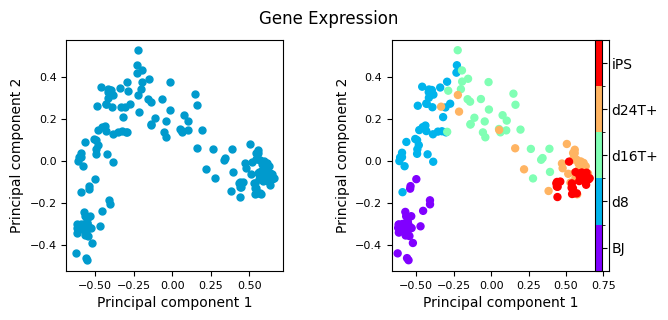

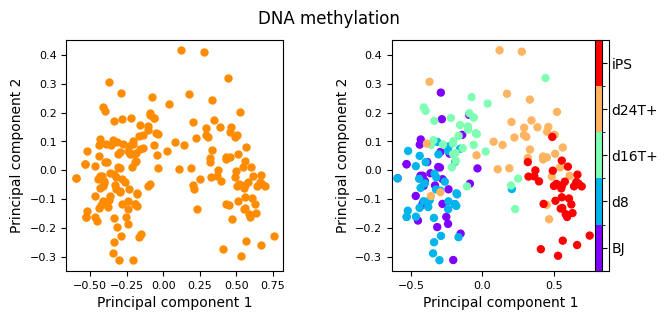

In [3]:
dm1_name = 'Gene Expression'
dm2_name = 'DNA methylation'
cell_labels = ["BJ", "d8", "d16T+", "d24T+", "iPS"]

# normalize data before models(SCOT/SONATA), you can also do this step within the models seperately
from sklearn.preprocessing import normalize
data1 = normalize(data1, norm='l2', axis=1)
data2 = normalize(data2, norm='l2', axis=1)

plt_domain_by_biolabels(data1, label1, color="#009ACD", title=dm1_name, y_tick_labels=cell_labels, show=True)
plt_domain_by_biolabels(data2, label2, color="#FF8C00", title=dm2_name, y_tick_labels=cell_labels, show=True)

### 2. Mapping by SCOT (or any other manifold aligners)

In [4]:
scot = scotv1.SCOT(data1.copy(), data2.copy())
scot.align(k = cfg.scot.k, e=cfg.scot.e, mode=cfg.scot.mode, metric=cfg.scot.metric, normalize=cfg.scot.normalize)
mapping = scot.coupling
x_aligned, y_aligned = projection_barycentric(scot.X, scot.y, mapping, XontoY = cfg.plt.XontoY)

It.  |Err         
-------------------
    0|5.704564e-03|
   10|4.347233e-04|
   20|2.750814e-06|
   30|3.261332e-08|
   40|4.543519e-10|


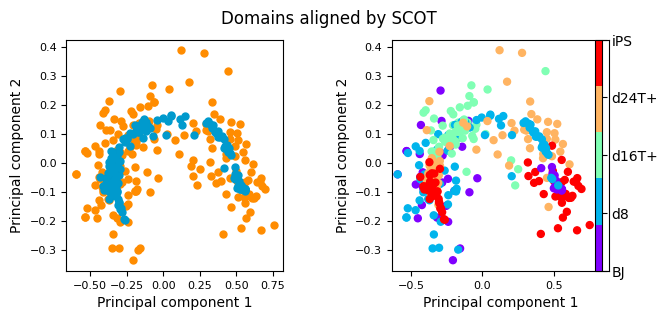

In [5]:
plt_mapping_by_biolabels(x_aligned, y_aligned, label1, label2, title1=dm1_name, title2=dm2_name, y_tick_labels=cell_labels, XontoY=cfg.plt.XontoY, show=True)

### 3. cell-cell alternaltive mappings from SONATA

In [6]:
sn = sonata.sonata(kmin=cfg.sonata.kmin, sigma=cfg.sonata.sigma, t=cfg.sonata.t)
alter_mappings = sn.alt_mapping(data=data1) 

constructing knn graph ...
final k =10
calculating cell-wise ambiguity ...
calculating group-wise ambiguity ...
deciding best k for clustering ...
K = 2 groups choosen by elbow method


#### 3.1 cell-cell ambiguities

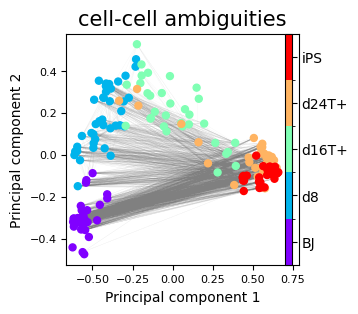

In [7]:
plt_cannotlink_by_biolabels(data1, sn.ambiguous_nodes, label1, sn.ambiguous_links, y_tick_labels=cell_labels, show=True)

#### 3.2 Ambiguous groups

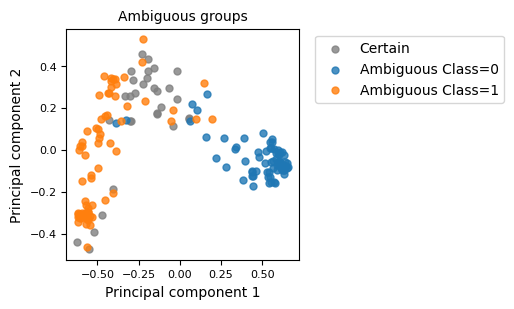

In [8]:
plt_ambiguous_groups_by_biolabels(data1, sn.ambiguous_nodes, sn.cluster_labels, alpha=0.8, show=True)

#### 3.3 Alternative alignments

all vaild perms are:  [(1, 0)]
perms:  (1, 0)
changed group id:  0 1
changed group id:  1 0


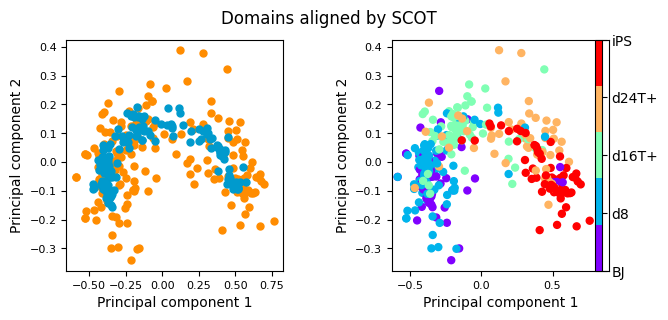

In [9]:

for idx, m in enumerate(alter_mappings, start=1):
    this_mapping = np.matmul(m, mapping)
    x_aligned, y_aligned = projection_barycentric(scot.X, scot.y, this_mapping, XontoY = cfg.plt.XontoY)
    plt_mapping_by_biolabels(x_aligned, y_aligned, label1, label2, title1=dm1_name, title2=dm2_name, y_tick_labels=cell_labels, XontoY=cfg.plt.XontoY, show=True)